In [1]:
%matplotlib inline

from matplotlib import pyplot

import geopandas as gpd
import numpy as np

import shapely.ops
import shapely.affinity as affine
import shapely.geometry as geom

from weavingspace.symmetry import Symmetries
import weavingspace.tiling_utils as tiling_utils
from weavingspace.tile_unit import TileUnit

### Some test polygons

In [2]:
polys = [
  tiling_utils.get_regular_polygon(1000, n = 4),
  tiling_utils.get_regular_polygon(1000, n = 5),
  TileUnit(tiling_type = "hex-dissection", n = 12).elements.geometry[0],
  TileUnit(tiling_type = "hex-dissection", n = 6).elements.geometry[1],
  TileUnit(tiling_type = "hex-dissection", n = 4).elements.geometry[0],
  TileUnit(tiling_type = "hex-dissection", n = 3).elements.geometry[0],
  affine.scale(tiling_utils.get_regular_polygon(1000, n = 3), 0.8, 0.9),
  TileUnit(tiling_type = "cairo", n = 3).elements.geometry[0],
  TileUnit(tiling_type = "archimedean", code = "4.8.8").elements.geometry[1]]

# translate to centroid (this is to make drawing easier, not required)
polys = [affine.translate(p, -p.centroid.x, -p.centroid.y) for p in polys]

/Users/osullid3/miniconda3/envs/weaving/lib/python3.12/site-packages/shapely/set_operations.py:419: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/Users/osullid3/miniconda3/envs/weaving/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


### Find symmetries

In [3]:
symmetries = [Symmetries(p) for p in polys]
symmetries[0].rotations, symmetries[0].reflection_axes

([0.0, 90.0, 180.0, 270.0], [45.0, 0.0, -45.0, -90.0])

### Plot them

/var/folders/63/53vsbnfn0ss3j4psxq2rr9jhrcmgg5/T/ipykernel_66240/3187814138.py:14: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  gpd.GeoSeries(ls).plot(ax = ax, color = "b", lw = 0.35)
/var/folders/63/53vsbnfn0ss3j4psxq2rr9jhrcmgg5/T/ipykernel_66240/3187814138.py:14: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  gpd.GeoSeries(ls).plot(ax = ax, color = "b", lw = 0.35)
/var/folders/63/53vsbnfn0ss3j4psxq2rr9jhrcmgg5/T/ipykernel_66240/3187814138.py:14: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  gpd.GeoSeries(ls).plot(ax = ax, color = "b", lw = 0.35)
/var/folders/63/53vsbnfn0ss3j4psxq2rr9jhrcmgg5/T/ipykernel_66240/3187814138.py:14: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  gpd.GeoSeries(ls).plot(ax = ax, color = "b", lw = 0.35)
/var/folders/63/53vsbnfn0ss3j4psxq2rr9jhrcmgg5/T/ipykernel_66240/318

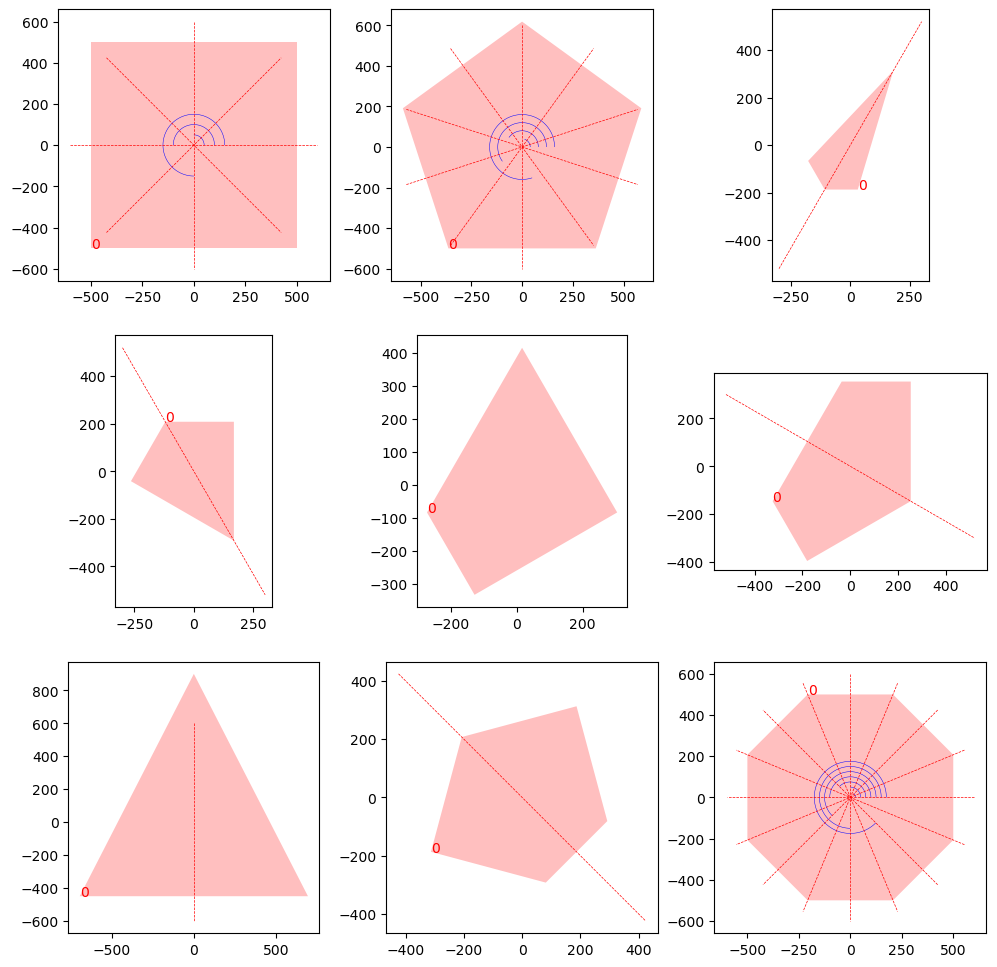

In [4]:
fig = pyplot.figure(figsize = (12, 12))
for poly, s, posn in zip(polys, symmetries, range(1, len(symmetries) + 1)):
  ax = fig.add_subplot(3, 3, posn)
  gpd.GeoSeries([poly]).plot(ax = ax, fc = "r", alpha = 0.25)

  w = 200 / len(s.rotations)
  ls = []
  for i, r in enumerate(s.rotations):
    if i > 0:
      ls.append(
        geom.LineString(
          [[w * i * np.cos(a), w * i * np.sin(a)] 
            for a in np.linspace(0, np.pi / 180 * r, 100)]))
  gpd.GeoSeries(ls).plot(ax = ax, color = "b", lw = 0.35)

  mirror_lines = s.reflection_axes
  if len(mirror_lines) > 0:
    gpd.GeoSeries(
      [affine.rotate(geom.LineString([(-600, 0), (600, 0)]), a) 
       for a in mirror_lines]).plot(
         ax = ax, color = "r", ls = "dashed", lw = 0.5)
  for i, p in enumerate(poly.exterior.coords):
    if i == 0:
      ax.annotate(text = i, xy = p, color = "r")